In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import itertools
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")
#plt.rcParams.update({'font.size': 15})
rcParams['figure.figsize'] = 20, 10

# Import Dataset:

In [2]:
dateparse = lambda date: pd.datetime.strptime(date, '%m/%d/%Y')
data= pd.read_csv('revFeul.csv' ,parse_dates=['Date'], index_col='Date',date_parser=dateparse)

In [3]:
#convert data into time-series with the feature you want to predict; 
#In this case we need to forcast demand for the fuel. 
ts=data['U.S. Gasoline Demand (Thousand Barrels per Day)']

In [4]:
ts.head()

Date
1993-07-16    8113
1993-07-23    7916
1993-07-30    7336
1993-08-06    8033
1993-08-13    7581
Name: U.S. Gasoline Demand (Thousand Barrels per Day), dtype: int64

In [5]:
ts.describe()

count    1316.000000
mean     8732.398936
std       628.102805
min      6321.000000
25%      8352.500000
50%      8852.000000
75%      9199.250000
max      9899.000000
Name: U.S. Gasoline Demand (Thousand Barrels per Day), dtype: float64

In [6]:
n_sample = ts.shape[0]
n_sample

1316

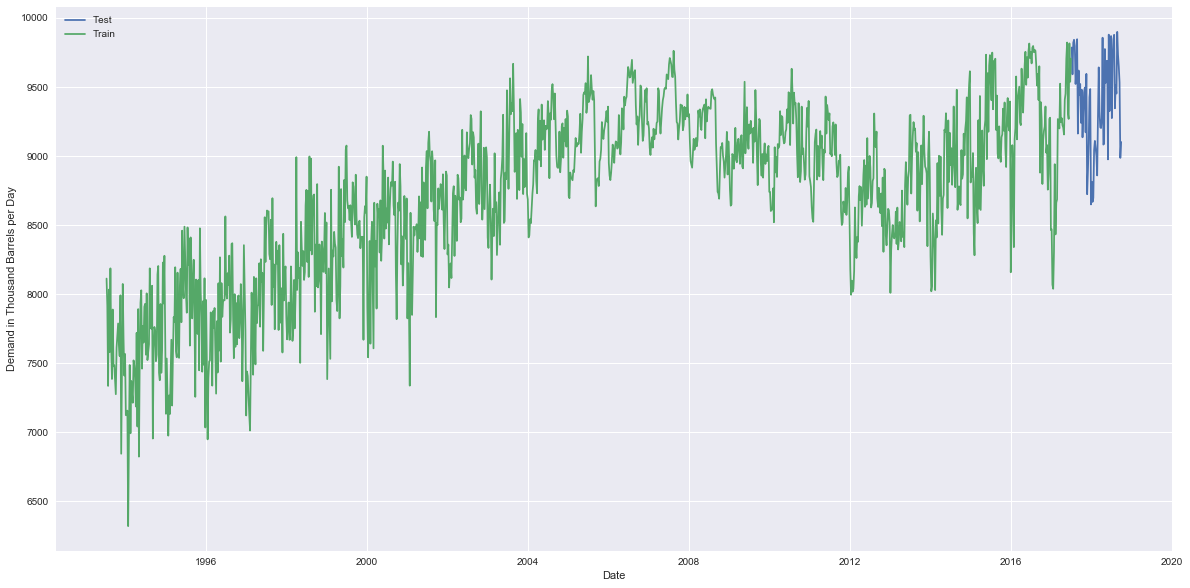

In [7]:
train= ts[:1251]
test= ts[1251:]
plt.plot(test,label='Test')
plt.plot(train,label='Train')
plt.legend(loc="best")
plt.xlabel('Date')
plt.ylabel('Demand in Thousand Barrels per Day')
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  

In [8]:
print(train.shape)
print(test.shape)
print("Training Series:", "\n", train.tail(), "\n")
print("Testing Series:", "\n", test.head())

(1251,)
(65,)
Training Series: 
 Date
2017-06-02    9317
2017-06-09    9269
2017-06-16    9816
2017-06-23    9538
2017-06-30    9705
Name: U.S. Gasoline Demand (Thousand Barrels per Day), dtype: int64 

Testing Series: 
 Date
2017-07-07    9786
2017-07-14    9592
2017-07-21    9821
2017-07-28    9842
2017-08-04    9797
Name: U.S. Gasoline Demand (Thousand Barrels per Day), dtype: int64


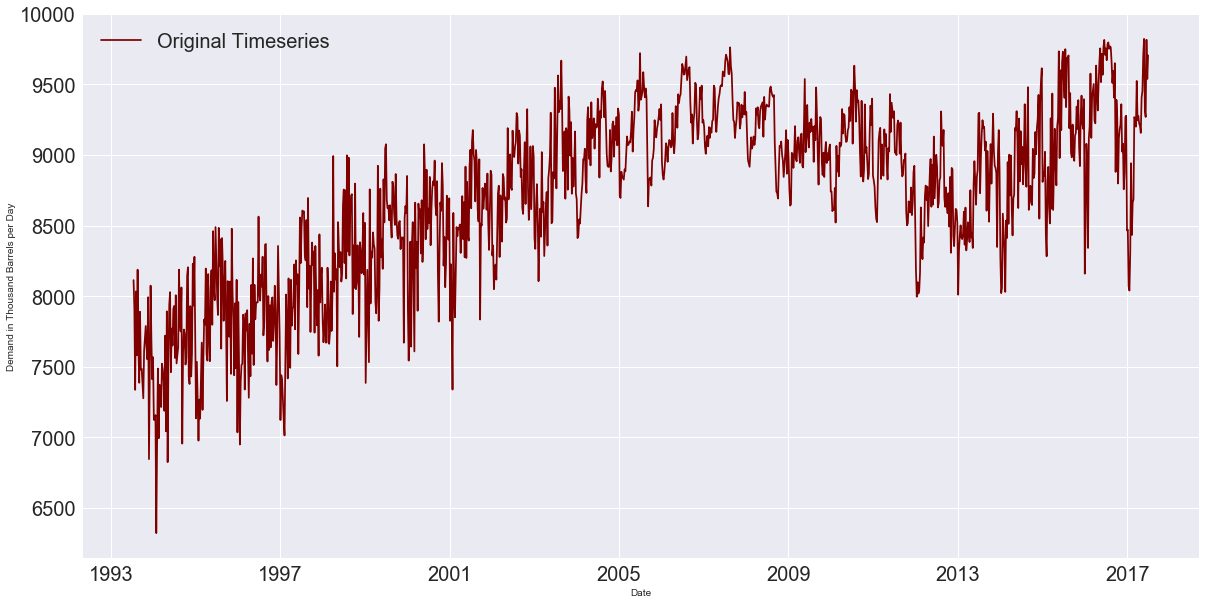

In [9]:
plt.plot(train, label='Original Timeseries', color='maroon')
plt.legend(loc="best")
plt.xlabel('Date')
plt.ylabel('Demand in Thousand Barrels per Day')
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  

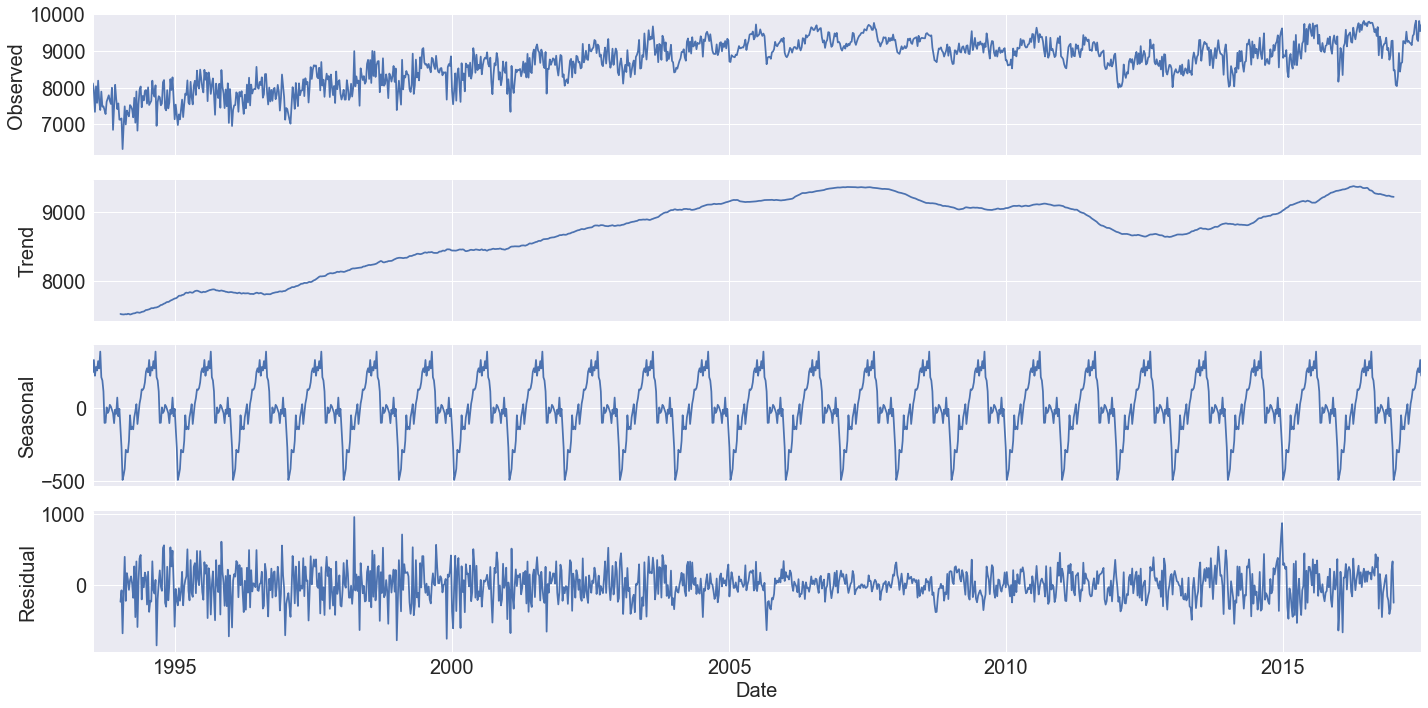

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decom= seasonal_decompose(train)
figs= decom.plot()
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  

# Making the time-series stationary
Our time series is in the form of Yt= (Deterministic part)+(Stochastic part)= F(t)+ Xt.
If we remove this determisistic part from our series, then the series will be stationary stochastic process. 
To remove this Determinictic part we will first find the polynimoial F(t) and then subtract it so all that is left is Xt.

Now fit try finding the polynomial that fits best the above points with least RSS. 

Converted dates Int64Index([ 742798800,  743403600,  744008400,  744613200,  745218000,
             745822800,  746427600,  747032400,  747637200,  748242000,
            ...
            1532667600, 1533272400, 1533877200, 1534482000, 1535086800,
            1535691600, 1536296400, 1536901200, 1537506000, 1538110800],
           dtype='int64', length=1316)
F(t)+Xt= [8113 7916 7336 ..., 9816 9538 9705]


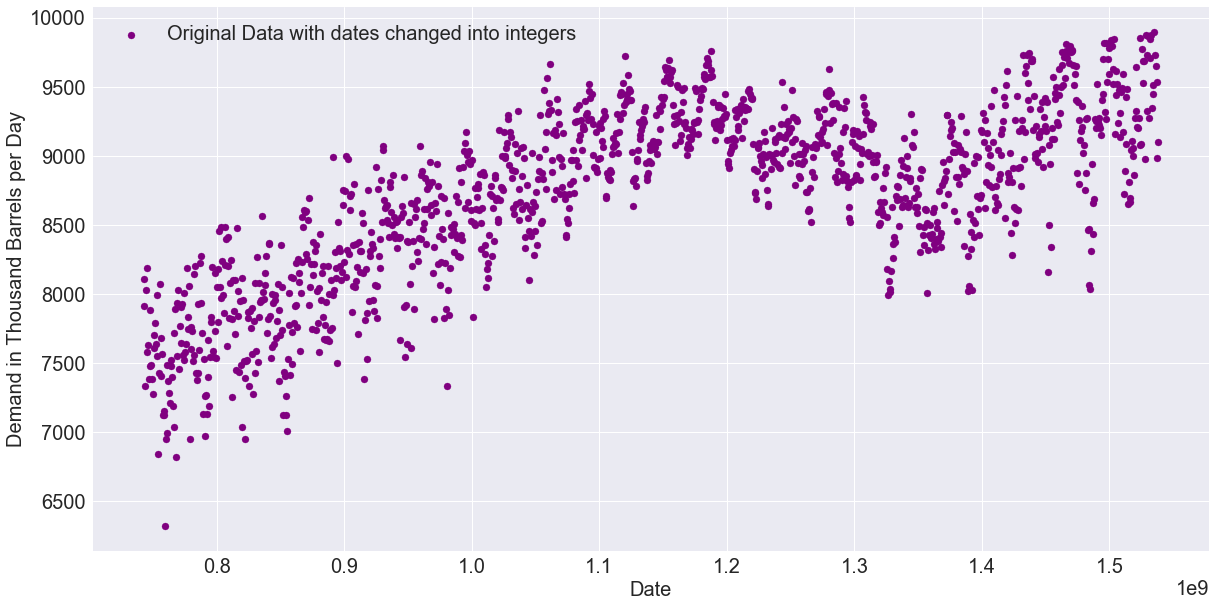

In [11]:
dates= (ts.index.strftime("%s").astype("int"))#convert date-time objects into integers.
vals= ts.values
print('Converted dates',dates)
print('F(t)+Xt=', train.values)
plt.scatter(dates,vals, label='Original Data with dates changed into integers', color='purple')
plt.xlabel('Date')
plt.ylabel('Demand in Thousand Barrels per Day')
plt.legend(loc=2 )
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  

# **Remove Trend:**

coefficient of the 4 polynomial are: [  2.37982828e+07  -1.74385775e-01   5.52735263e-10  -9.89278176e-19
   1.09330920e-27  -7.63863523e-37   3.29453883e-46  -8.01968021e-56
   8.43625474e-66]
Statistics of the 4 deg polynomial are: [array([  1.41165972e+08]), 9, array([  2.87424223e+00,   8.43332771e-01,   1.64552784e-01,
         2.09785145e-02,   1.92915608e-03,   1.32475118e-04,
         6.81437006e-06,   2.53662125e-07,   6.02271078e-09]), 2.922107000813412e-13]
141165972.019


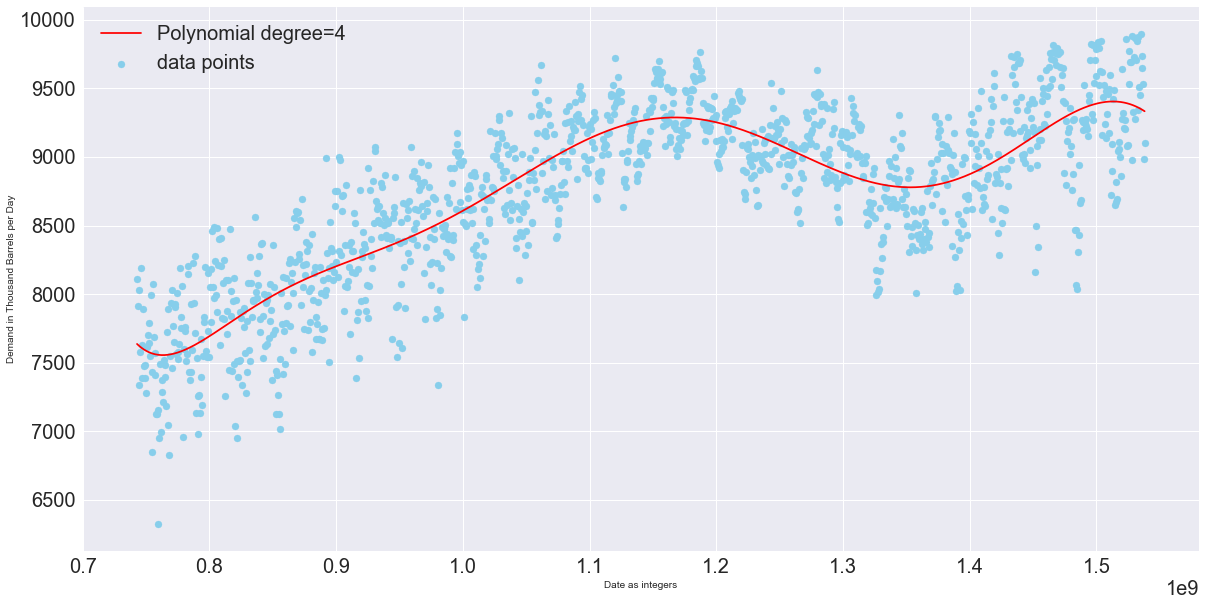

In [12]:
import numpy.polynomial.polynomial as poly
pol, stat= poly.polyfit(dates, vals, 8, full=True)
print('coefficient of the 4 polynomial are:', pol)
print('Statistics of the 4 deg polynomial are:', stat)

ffit = poly.polyval(dates,pol)
plt.plot(dates, ffit, color='red',label='Polynomial degree=4') 
plt.scatter(dates,vals, label='data points', color='skyblue')
plt.xlabel('Date as integers')
plt.ylabel('Demand in Thousand Barrels per Day')
plt.legend(loc=2)

RSS =np.sum((vals- ffit)**2)
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
print(RSS)

# Remove Deterministic part:
Yt= Xt...after removal of F(t)

In [13]:
season = ts - ffit

# Autocorrelations:
- $Xt$ is now linear combination of some disturbances ($at$'s with Greens funtion as the coefficients) with multivariate normal distribution with mean zero. 
- Autocorrelation function and Partial Autocorrelation function help us guess the form of ARMA model which we will fit later to the stochastic period $Xt$. However this can be a poor estimate of the model and hence we need fit all the possible $ARMA(2n,2n-1)$ models and check them with Ftest.

- The Autocorrelation and Autocovarinace funtion will tell us the dependnce of $Xt$ on $Xt-k$.
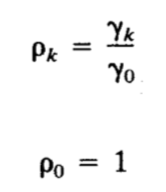
- Note that when $k = 0$ , Autocorrelation is 1, that is just the variance of at.
We can cross check our model looking at the graph of acf and pacf. 
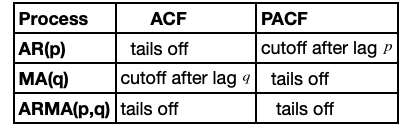

Text(0,0.5,'Partial_AutoCorrelation')

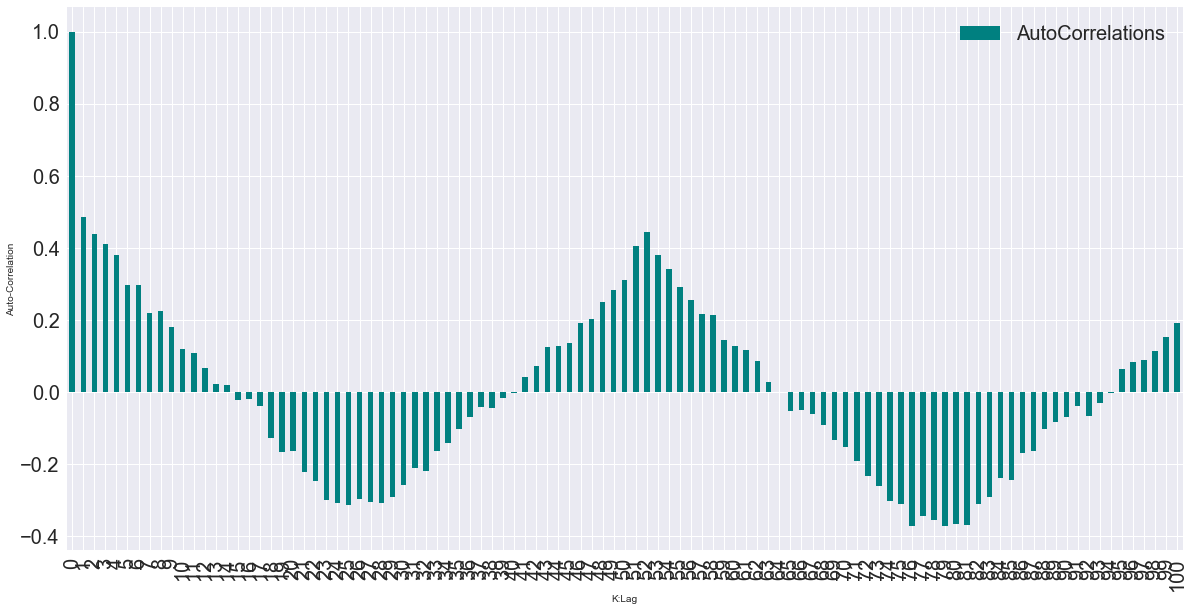

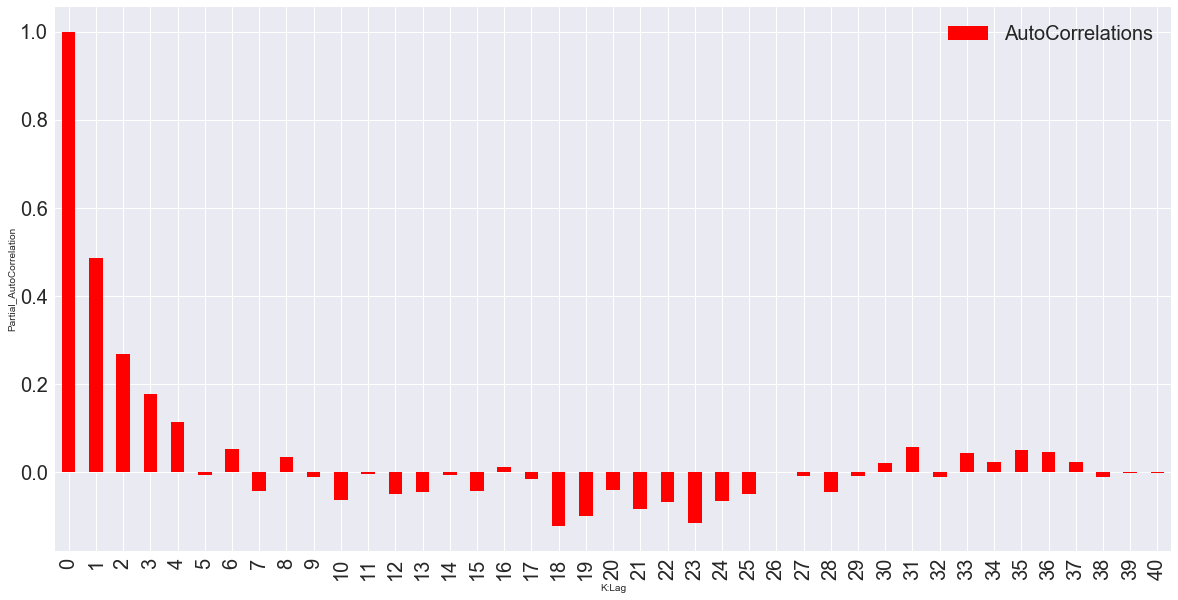

In [14]:
from statsmodels.tsa.stattools import acf, pacf 
acf = acf(season, nlags=100)
acf_df= pd.DataFrame([acf]).T
acf_df.columns=["AutoCorrelations"]
acf_df.index +=0
acf_df.plot(kind='bar', color='teal')
plt.xlabel('K:Lag')
plt.ylabel('Auto-Correlation')

pacf=pacf(season)
pacf_df= pd.DataFrame([pacf]).T
pacf_df.columns=["AutoCorrelations"]
pacf_df.index +=0
pacf_df.plot(kind='bar', color='red')
plt.xlabel('K:Lag')
plt.ylabel('Partial_AutoCorrelation')

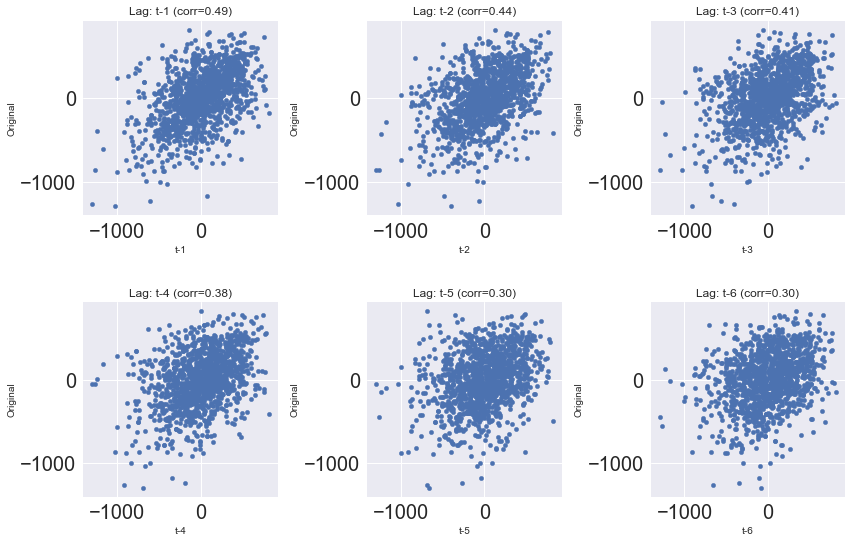

In [15]:
lags=6

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([season, season.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20) 
fig.tight_layout();

In [16]:
season.head()

Date
1993-07-16    476.812144
1993-07-23    285.083723
1993-07-30   -289.853411
1993-08-06    412.004217
1993-08-13    -35.339956
dtype: float64

Text(0,0.5,'Demand in Thousand Barrels per Day')

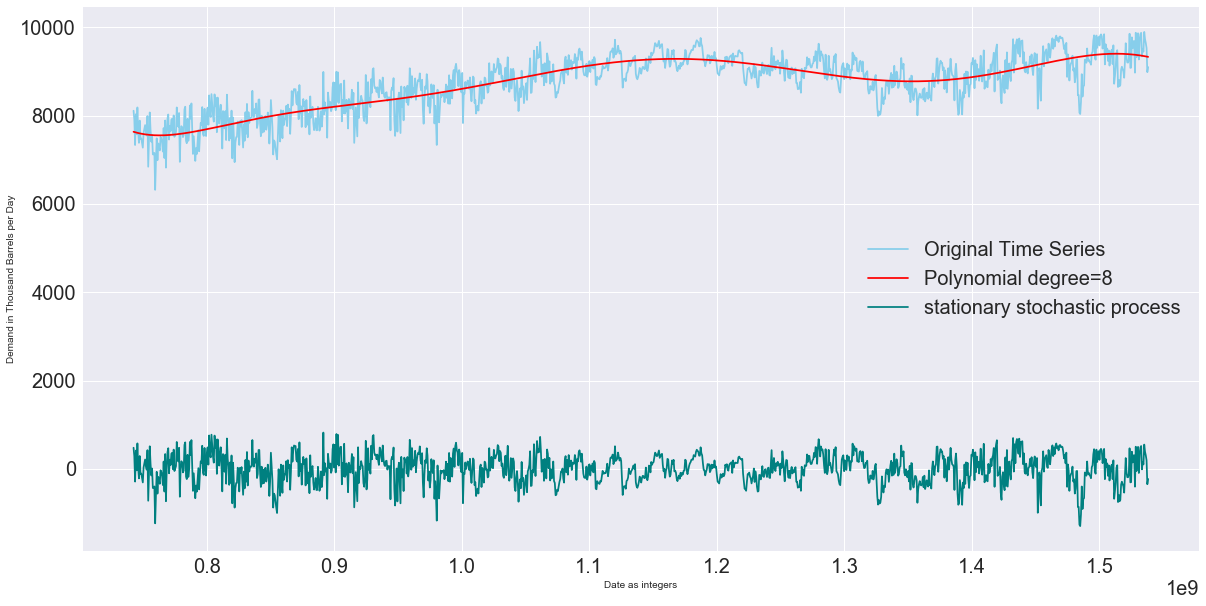

In [17]:
plt.plot(dates,vals, label="Original Time Series", color='skyblue')
plt.plot(dates, ffit, color='red',label='Polynomial degree=8') 
plt.plot(dates, season, color='teal', label='stationary stochastic process') 
plt.legend(loc= 'best')
plt.xlabel('Date as integers')
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
plt.ylabel('Demand in Thousand Barrels per Day')

-6.594839520005108e-07


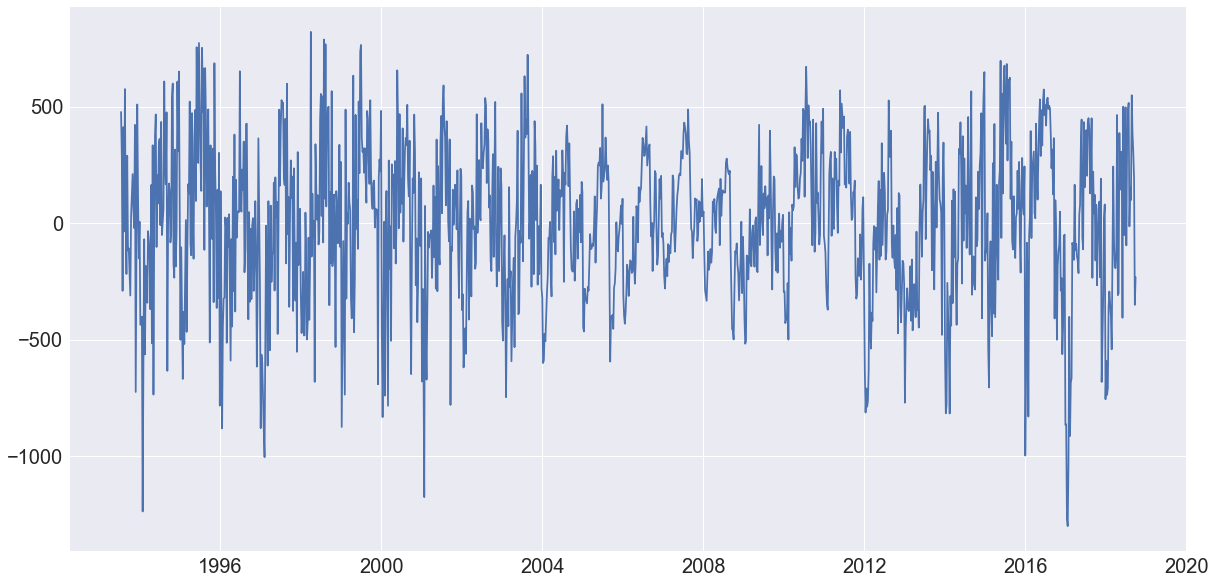

In [18]:
guess_mean = np.mean(season)
guess_std = 3*np.std(season)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
t=season.index
print(guess_mean)
plt.plot(season)

## **Remove Seasonality: **

- coefficients of our polynomial looks like they're the best initial guess for the polynomial.  

parameters of the curve: [  6.40367813e+02   1.27012829e-05  -4.72397242e-15   1.88109425e-18
   1.20757574e-18]
parameters of polynomial: [  2.37982828e+07  -1.74385775e-01   5.52735263e-10  -9.89278176e-19
   1.09330920e-27  -7.63863523e-37   3.29453883e-46  -8.01968021e-56
   8.43625474e-66]


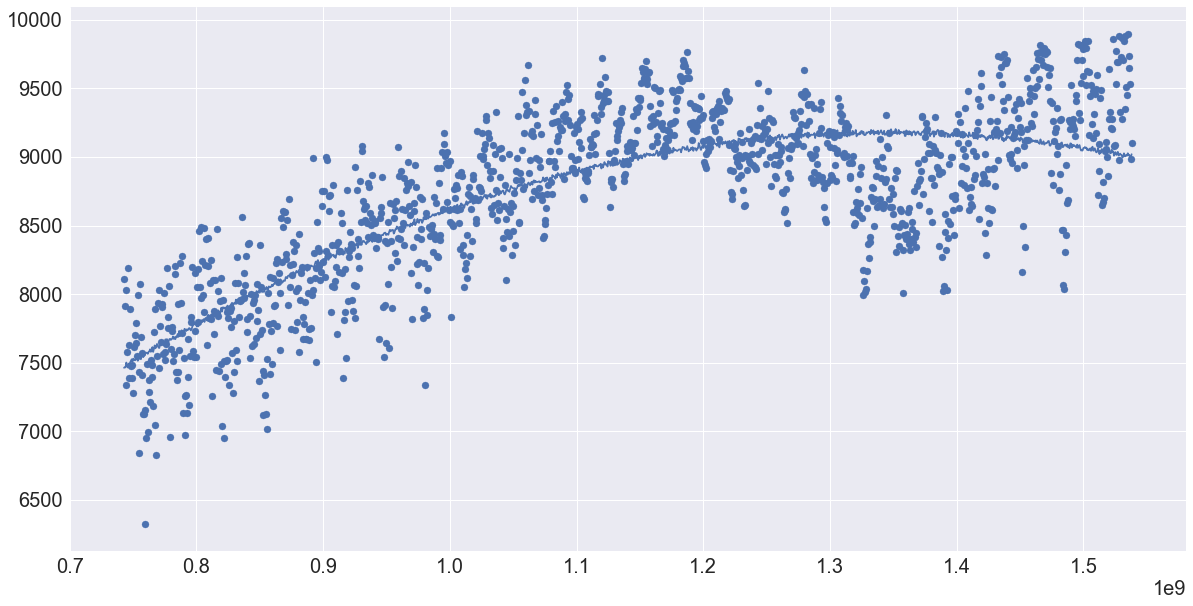

In [19]:
def func(x,a,b,c,d,e):
    return a + (b*x) + (c*x**2) +(d*x**3) +(e*x**4)


#initial_guess=[*pol]
pars,pcov=curve_fit(func,dates,vals)
print('parameters of the curve:',pars)
print('parameters of polynomial:',pol)
ypred= func(dates, *pars)
plt.plot(dates,ypred)
plt.scatter(dates, vals)

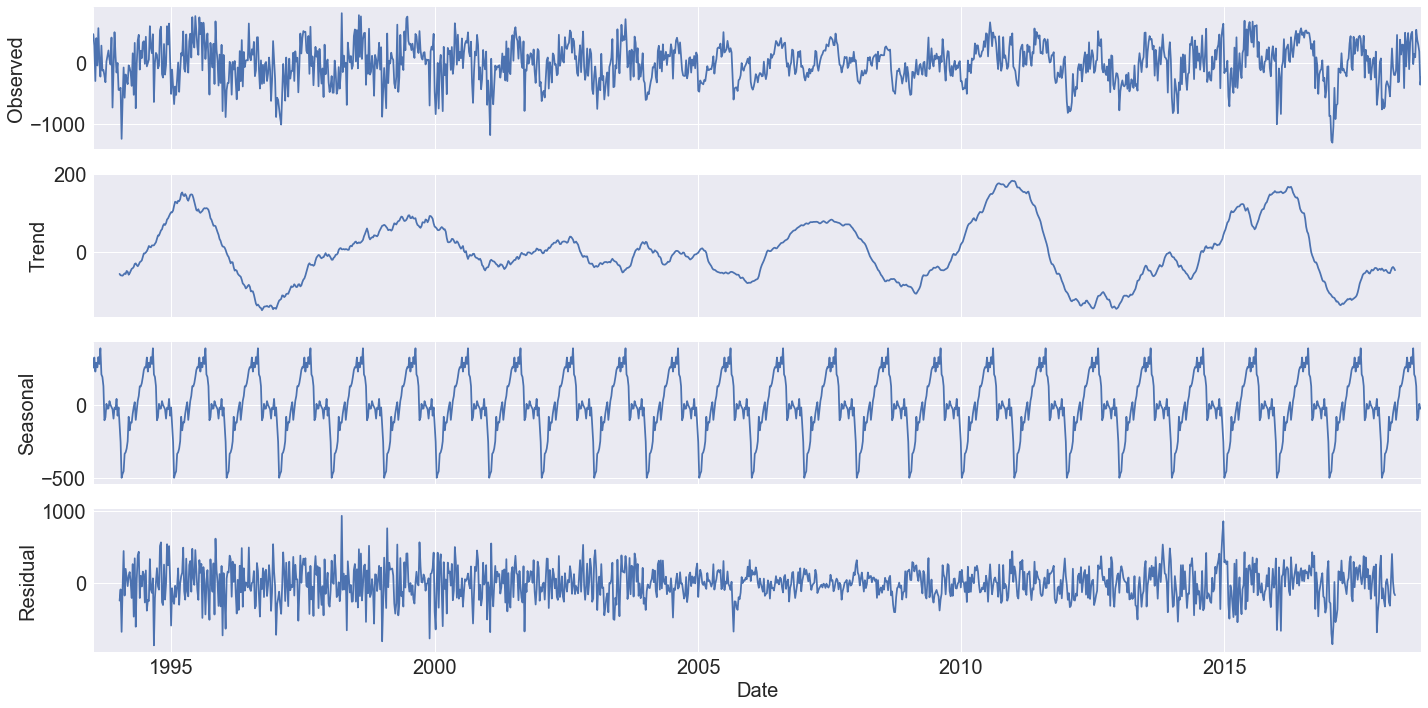

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp= seasonal_decompose(season)
fig= decomp.plot()

In [21]:
#Xt = season - decomp.seasonal

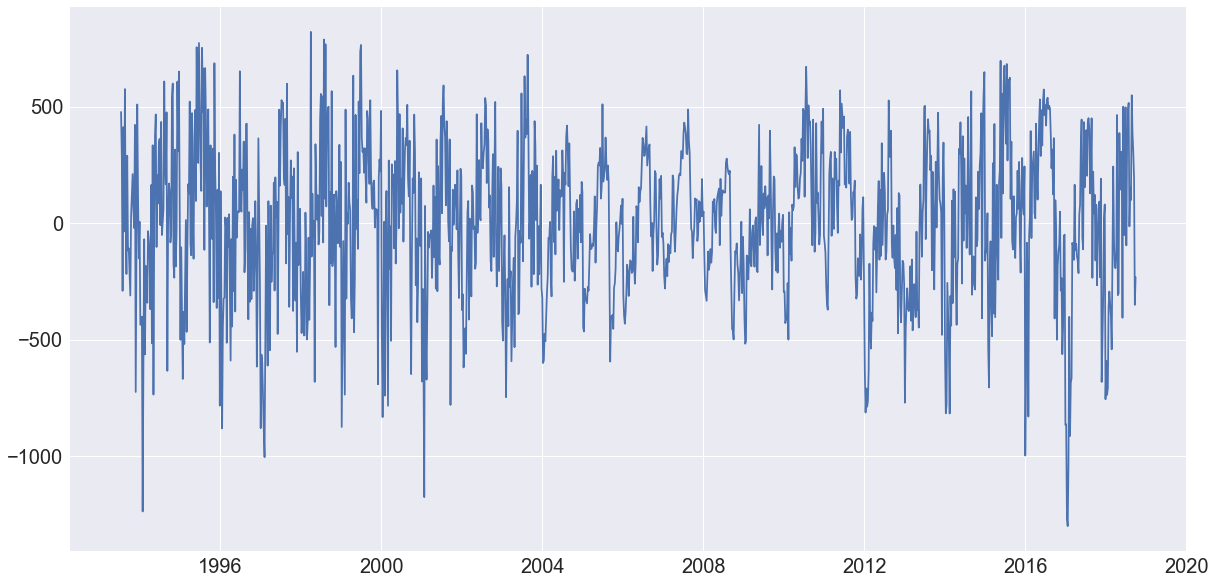

In [22]:
plt.plot(season)

# Test stationarity:

In [23]:
#test of stationarity:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean =  pd.Series(timeseries).rolling(window=4).mean()
    rolstd = pd.Series(timeseries).rolling(window=4).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='skyblue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='purple', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


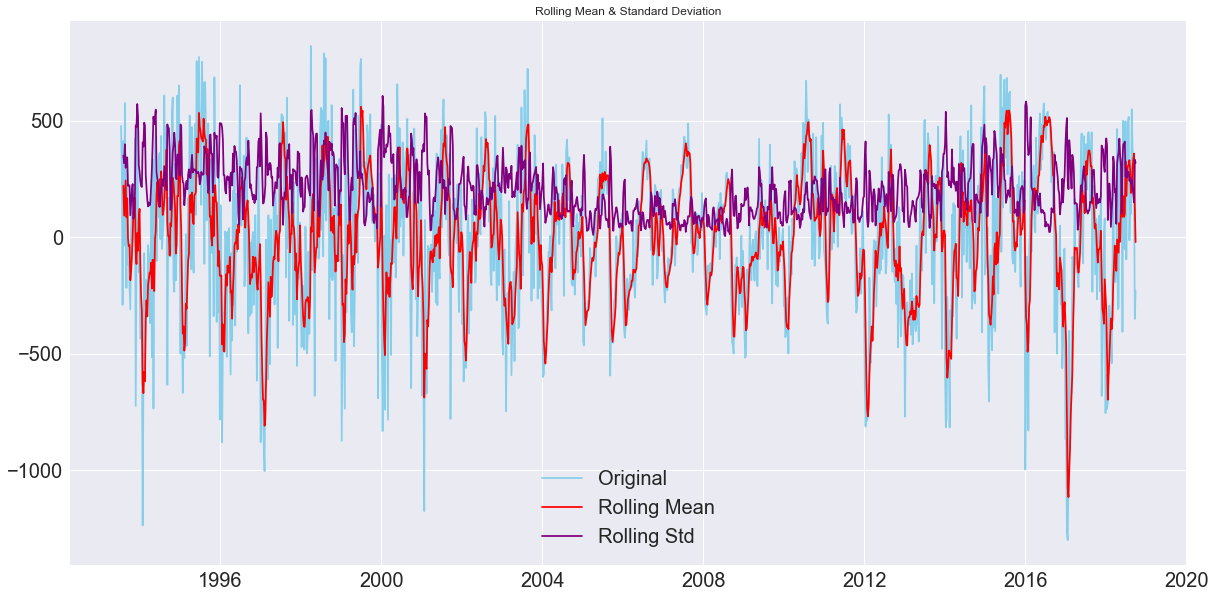

Results of Dickey-Fuller Test:
Test Statistic                -1.125156e+01
p-value                        1.707051e-20
#Lags Used                     2.300000e+01
Number of Observations Used    1.292000e+03
Critical Value (1%)           -3.435421e+00
Critical Value (5%)           -2.863780e+00
Critical Value (10%)          -2.567962e+00
dtype: float64


Text(0,0.5,'Demand in Thousand Barrels per Day')

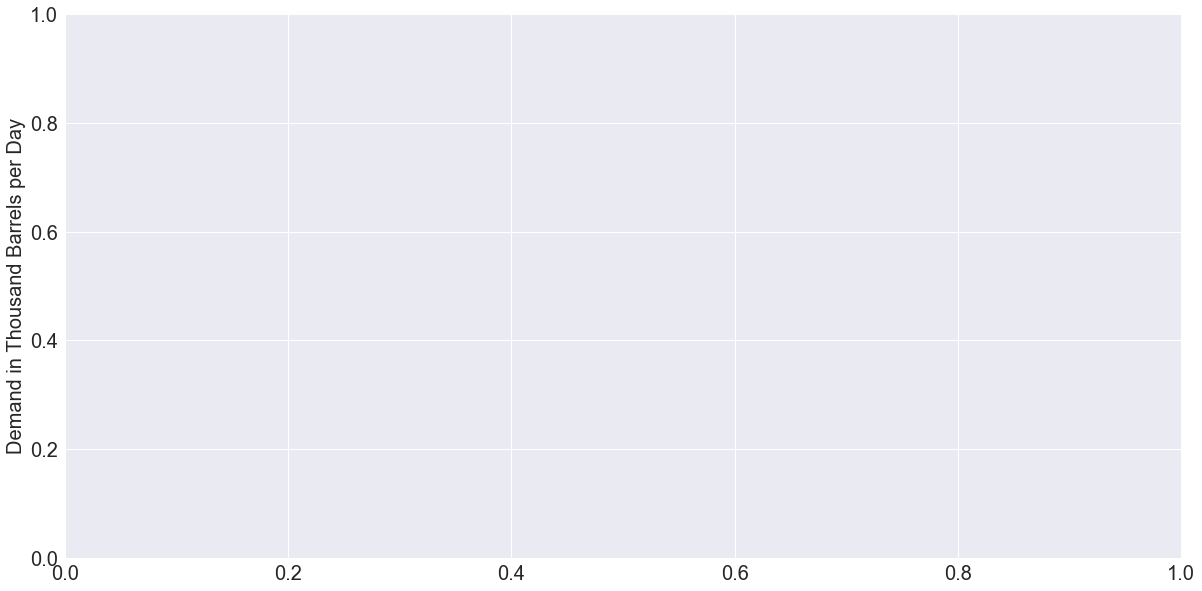

In [24]:
test_stationarity(season)
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
plt.ylabel('Demand in Thousand Barrels per Day')

# ARMA(n,m) modelling:

*Now that we have removed the deterministic part we can apply $ARMA(n,m)$ on the stationary stochastic part $Xt$.*
- Before we fit models, we split data into training sample dataset and testing (forcasting) dataset. Note: Do not randomely select the data points as it will break the depencey structure of the data. Lets select **95%** of the data from the begining for training to fit our models and test these models to forecast last **5%** of the data points.


In [25]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

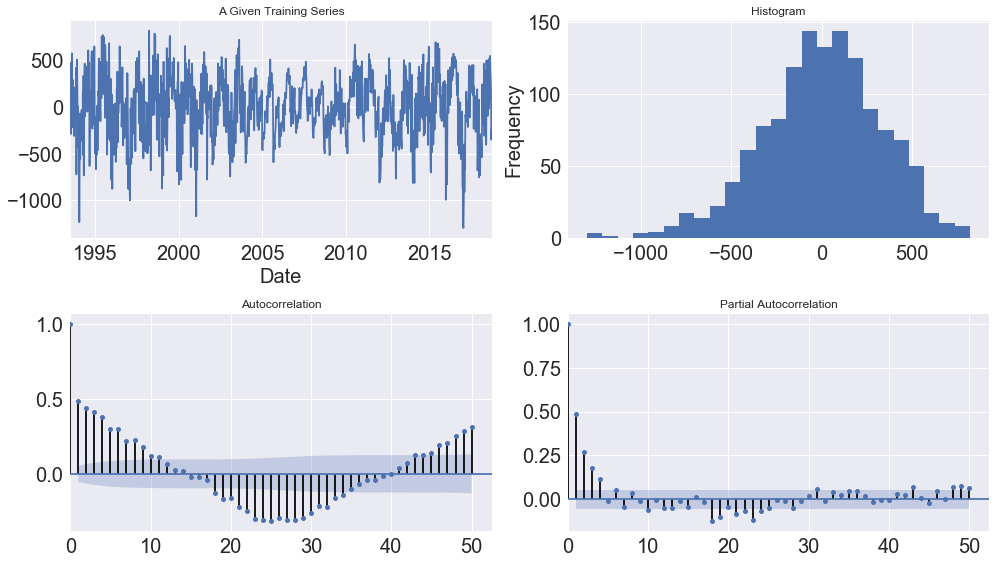

In [26]:
tsplot(season, title='A Given Training Series', lags=50);

*** Observations from the sample ACF and sample PACF (based on first 50 lags)***
- The sample Acf gradually tails off at observation number **18**
- The sample pacf does not exactly cut off at some lag $p$ but does not exactly tail off either.
- According to the text book chapter 4 of time series, we shall now proceed with fitting $ARMA(2n,2n-1)$ models with n=1,2,..
- How do we guess our model is (almost) correct? 
 1. The residual error must follow the white noise assumption. That is our residuals should be a series of Independently-Identically-distributed normal random variables. 
 2. Also the residual error must follow all the underlying assumption for that model. 

**ARMA model format**

$ \Phi_P(B^s)z_t=\Theta_Q(B^s)\ \epsilon_t\ $

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1316
Model:                     ARMA(2, 0)   Log Likelihood               -9262.997
Method:                       css-mle   S.D. of innovations            275.794
Date:                Fri, 10 May 2019   AIC                          18533.995
Time:                        16:02:49   BIC                          18554.724
Sample:                    07-16-1993   HQIC                         18541.768
                         - 09-28-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3121     20.172      0.015      0.988     -39.225      39.849
ar.L1.y        0.3564      0.027     13.421      0.000       0.304       0.408
ar.L2.y        0.2674      0.027     10.062      0.0

Text(0,0.5,'Demand in Thousand Barrels per Day')

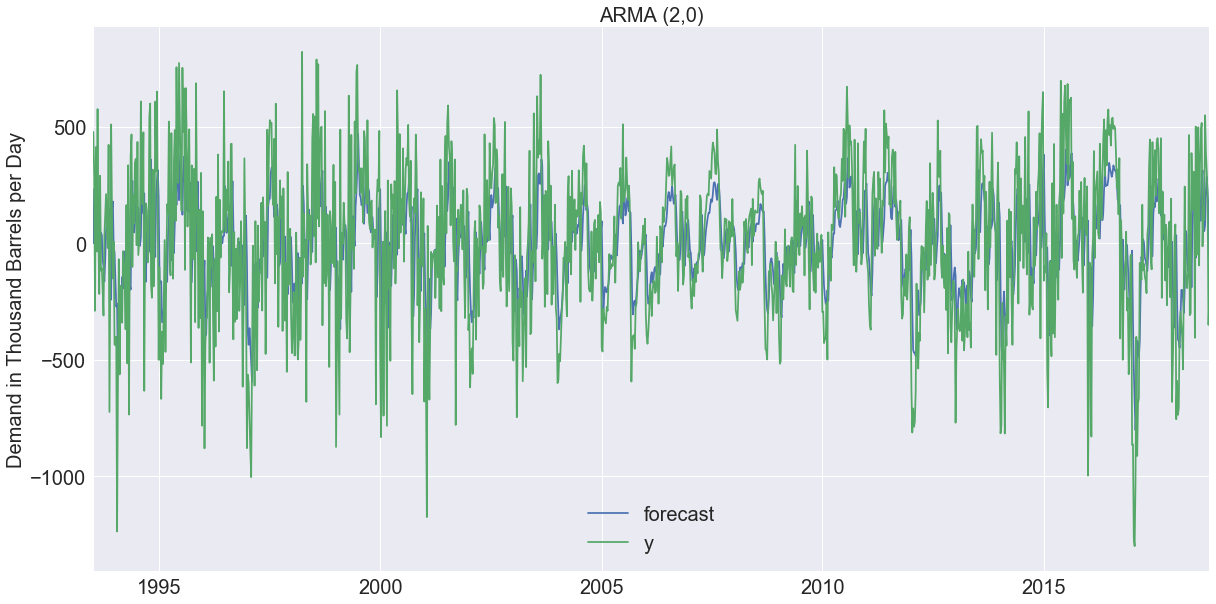

In [27]:
ARMA20= sm.tsa.ARMA(season,order=(2,0))
model20_results = ARMA20.fit() 
print(model20_results.summary())
print("RSS of ARMA(2,0) is : ",np.sum(model20_results.resid**2))
fig1=model20_results.plot_predict()
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
plt.title('ARMA (2,0)', fontsize=20)
plt.ylabel('Demand in Thousand Barrels per Day')

                           Results: ARMA
Model:              ARMA             BIC:                 18509.2074
Dependent Variable: y                Log-Likelihood:      -9236.6   
Date:               2019-05-10 16:02 Scale:               1.0000    
No. Observations:   1316             Method:              css-mle   
Df Model:           4                Sample:              07-16-1993
Df Residuals:       1312                                  09-28-2018
Converged:          1.0000           S.D. of innovations: 270.314   
No. Iterations:     22.0000          HQIC:                18493.012 
AIC:                18483.2956                                      
----------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025     0.975]
----------------------------------------------------------------------
const       0.9144    28.3518     0.0323   0.9743   -54.6540   56.4829
ar.L1.y     0.8396     0.0564    14.8883   0.0000     

Text(0,0.5,'Demand in Thousand Barrels per Day')

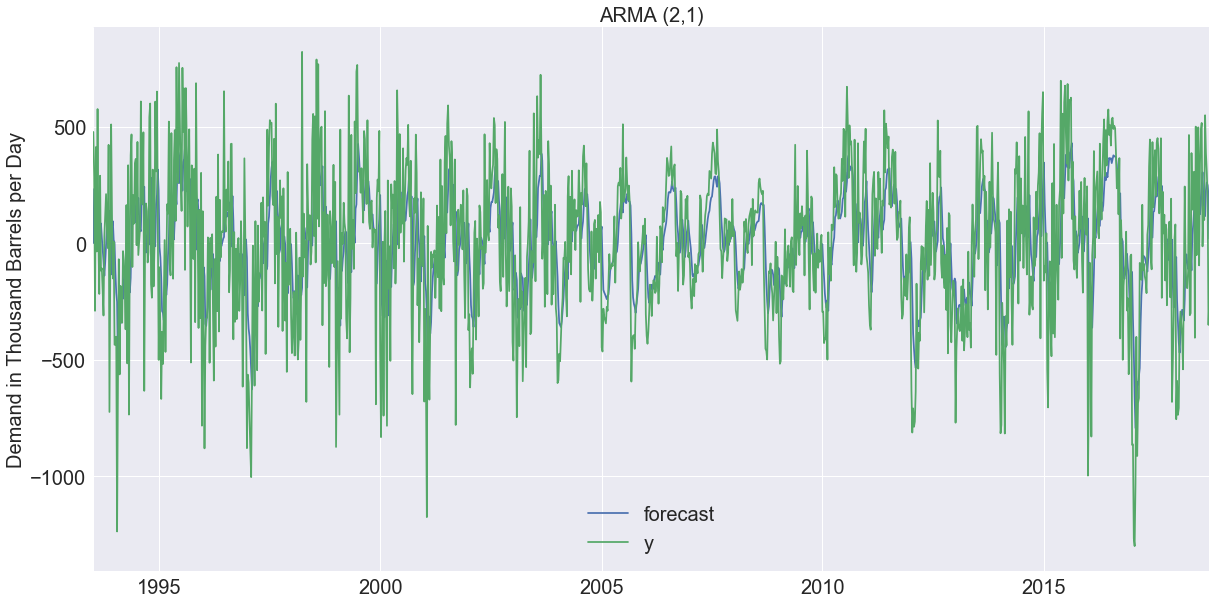

In [28]:
ARMA21= sm.tsa.ARMA(season,order=(2,1))
model21_results = ARMA21.fit()
print(model21_results.summary2())
print("RSS of ARMA(2,1) is : ",np.sum(model21_results.resid**2))
fig1=model21_results.plot_predict()
plt.rc('legend', fontsize= 20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
plt.title('ARMA (2,1)', fontsize=20)
plt.ylabel('Demand in Thousand Barrels per Day')

In [29]:
re= decomp.resid.dropna()

# Best model ARMA: 

In [30]:
# Now lets perform all the possible ARMA combinations:

p_min = 0
q_min = 0
p_max = 6
q_max = 6
d = 0
# Initialize a DataFrame to store the results
results_resid = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,q in itertools.product(range(p_min,p_max+1),
                               range(q_min,q_max+1)):
    if p==0 and q==0:
        results_resid.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.ARIMA(season, order=(p, d, q),
                            
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_resid.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.sum(results.resid**2)
    except:
        continue
results_resid = results_resid[results_resid.columns].astype(float)

In [31]:
results_resid

,MA0,MA1,MA2,MA3,MA4,MA5,MA6
AR0,NaN,1.192828e+08,1.112084e+08,1.063395e+08,1.012100e+08,1.003634e+08,9.820185e+07
AR1,1.078630e+08,9.631929e+07,9.622821e+07,9.601330e+07,9.594180e+07,9.587594e+07,9.541941e+07
AR2,1.001644e+08,9.624234e+07,9.612444e+07,9.611072e+07,NaN,NaN,NaN
AR3,9.707407e+07,9.604972e+07,9.611429e+07,NaN,NaN,NaN,NaN
AR4,9.584178e+07,9.570707e+07,NaN,NaN,NaN,NaN,NaN
AR5,9.583502e+07,9.560186e+07,9.549799e+07,NaN,NaN,NaN,NaN
AR6,9.557175e+07,9.537723e+07,9.472253e+07,9.472256e+07,NaN,NaN,NaN


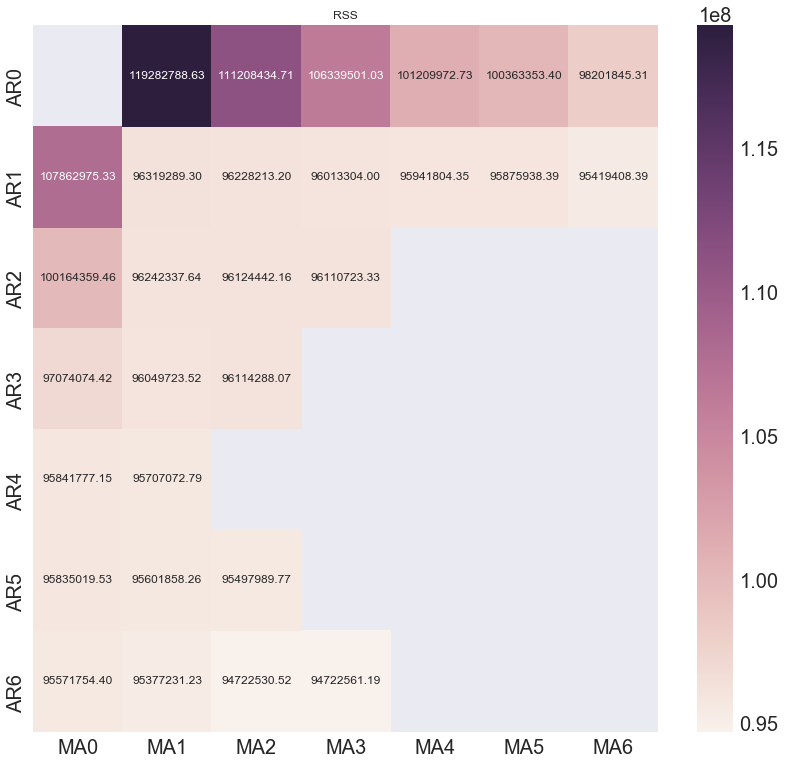

In [32]:
fig, ax = plt.subplots(figsize=(14, 13))
ax = sns.heatmap(results_resid,
                 mask=results_resid.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('RSS');

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1316
Model:                     ARMA(6, 2)   Log Likelihood               -9226.108
Method:                       css-mle   S.D. of innovations            268.142
Date:                Fri, 10 May 2019   AIC                          18472.215
Time:                        16:03:10   BIC                          18524.039
Sample:                    07-16-1993   HQIC                         18491.648
                         - 09-28-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8064     27.140      0.030      0.976     -52.387      54.000
ar.L1.y       -0.9692      0.113     -8.570      0.000      -1.191      -0.748
ar.L2.y       -0.3003      0.069     -4.373      0.0

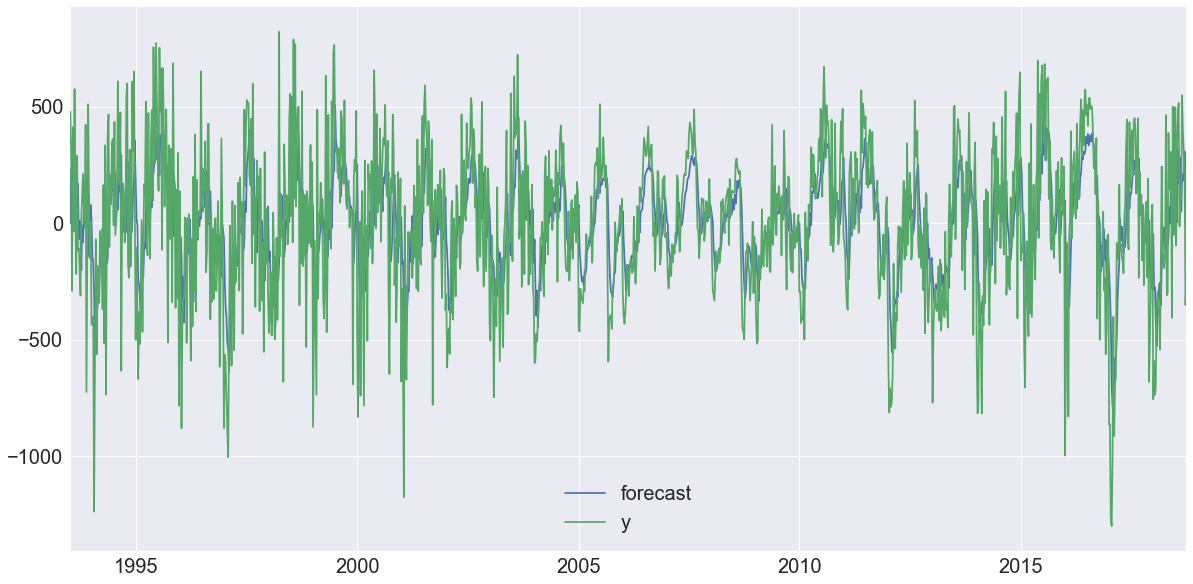

In [33]:
ARMA62 = sm.tsa.ARIMA (season, order=(6,0,2))
model62_results = ARMA62.fit()
print(model62_results.summary())
print("RSS of ARMA(6,2) is : ",np.sum(model62_results.resid**2))
fig1=model62_results.plot_predict()

# Model check:
- After selecting the best model we will check the behaviour of te residuals. 
- Our model is acceptable only when the residuls follow the white noise.
- The residuls $at$'s must also agree with the assumption of NID. 
- $at$'s must not show any autocorrelations in acfs and pacfs plots.


# Model performance evaluation (in-sample fit)


In [34]:
ts_train= season[:1000]
ts_test = season[1000:]

In [53]:
# # fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
# # ax1.plot(ts_train, label='In-sample data', linestyle='-')
# # # subtract 1 only to connect it to previous point in the graph
# # ax1.plot(ts_test, label='Held-out data', linestyle='--')

# # # yes DatetimeIndex
# pred_begin = ts_train.index[1]
# pred_end = ts_test.index[-1]
# pred = model62_results.predict(start=pred_begin.strftime('%Y-%m-%d'),
#                                      end=pred_end.strftime('%Y-%m-%d'))
# pred_mean = pred.mean
# pred_ci = pred.conf_int(alpha=0.05)

# ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
# ax1.fill_between(pred_ci.index,
#                   pred_ci.iloc[:, 0],
#                   pred_ci.iloc[:, 1], color='k', alpha=.2)

# ax1.legend(loc='best');

In [39]:
# def get_rss(y, y_hat):
#     '''Root Mean Square Error
#     '''
#     RSS = np.sum((y - y_hat)**2)
#     return RSS

# def get_mape(y, y_hat):
#     '''Mean Absolute Percent Error
#     '''
#     perc_err = (100*(y - y_hat))/y
#     return np.mean(abs(perc_err))

In [54]:
# RSS = get_rss(ts_train, pred_mean.ix[ts_train.index])
# print("RSS of our in-sample model: ", RSS)
# mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
# print("Mean percent error of our in-sample model: ", mape)

In [ ]:
# RSStest = get_rss(ts_test, pred_mean.ix[ts_test.index])
# print("RSS of our held out data: ",RSStest)

# mape2 = get_mape(ts_test, pred_mean.ix[ts_test.index])
# print('Mean percent error of our held out data',mape2)

# Forecast by Arima(6,2):

In [50]:
model62_results.forecast(4)

(array([   1.15613197, -120.05559482,  -91.08525945,  -35.52300334]),
 array([ 268.14152008,  279.84060372,  288.57832409,  297.16187083]),
 array([[-524.39159016,  526.70385409],
        [-668.53309952,  428.42190988],
        [-656.68838139,  474.51786248],
        [-617.94956774,  546.90356107]]))

# Seasonal ARMA modelling:


$\Theta_Q(B^h)=1 - \Theta_1 B^h - \Theta_2 B^{2h} - \cdots - \Theta_Q B^{Qh}$

where, 

$ \Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$

$ \Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots -\Theta_Q B^{Qs}$

- Note that we use (p,q) to denote the orders for the non-seasonal components of the ARMA models and (P,Q,s) to denote the orders for the seasonal components of the ARMA model.

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1316
Model:             SARIMAX(6, 0, 2)x(1, 0, 1, 6)   Log Likelihood               -9224.924
Date:                           Fri, 10 May 2019   AIC                          18471.847
Time:                                   16:17:07   BIC                          18528.853
Sample:                               07-16-1993   HQIC                         18493.223
                                    - 09-28-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9444      0.099     -9.587      0.000      -1.137      -0.751
ar.L2         -0.2638      0.083     -3.169

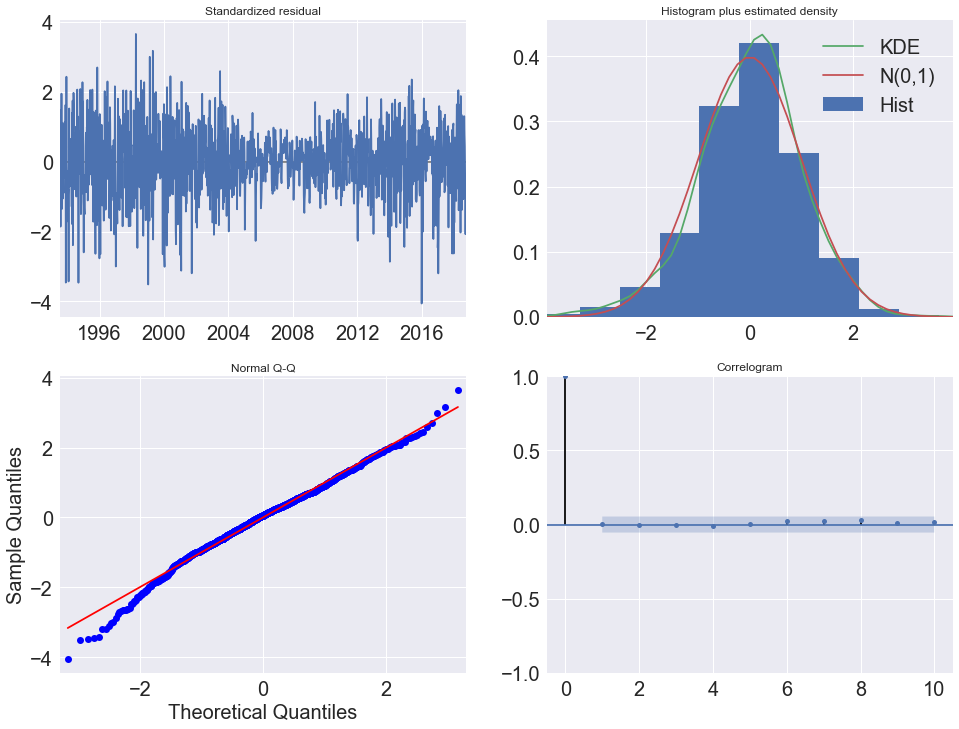

In [55]:
mod = sm.tsa.statespace.SARIMAX(season, order=(6,0,2), seasonal_order=(1,0,1,6), simple_differencing=True)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())
fig2= sarima_fit1.plot_diagnostics(figsize=(16, 12))
print("RSS=",np.sum(sarima_fit1.resid**2))

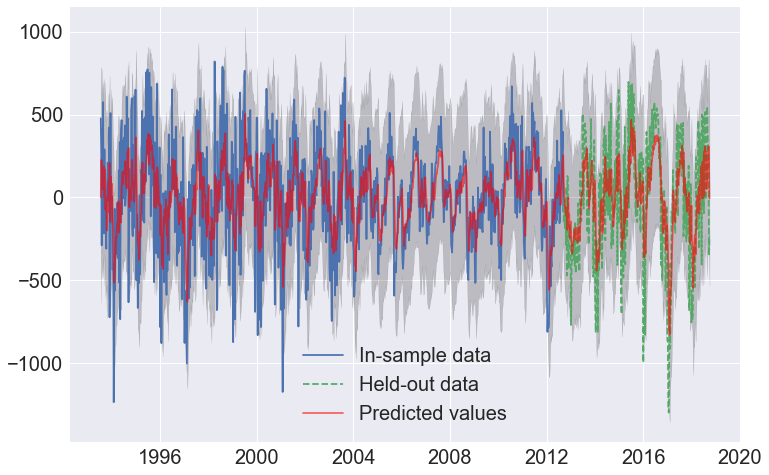

In [56]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit1.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit1.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');